# 项目5-迁移学习

## 友情提示
同学们可以前往课程作业区先行动手尝试！！！

## 项目描述
本作业的任务是迁移学习中的领域对抗性训练(Domain Adversarial Training)。
![](https://ai-studio-static-online.cdn.bcebos.com/0aa95ffac5414622a0588283f09087b2fbacebfb5a8f4e449d4ed62d740ca868)

> 也就是左下角的那一块。

Domain Adaptation是让模型可以在训练时只需要 A dataset label，不需要 B dataset label 的情况下提高 B dataset 的准确率。 （A dataset & task 接近 B dataset & task）也就是给定真实图片 & 标签以及大量的手绘图片，请设计一种方法使得模型可以预测出手绘图片的标签是什么。

## 数据集介绍
这次的任务是源数据: 真实照片，目标数据: 手画涂鸦。

我们必须让model看过真实照片以及标签，尝试去预测手画涂鸦的标签为何。

资料位于'data/data58171/real_or_drawing.zip'

* Training : 5000 张真实图片 + label, 32 x 32 RGB
* Testing : 100000 张手绘图片，28 x 28 Gray Scale
* Label: 总共需要预测 10 个 class。
* 资料下载下来是以 0 ~ 9 作为label

特别注意一点: **这次的源数据和目标数据的图片都是平衡的，你们可以使用这个资料做其他事情。 **

## 项目要求

* 禁止手动标记label或在网上寻找label
* 禁止使用pre-trained model

## 数据准备

In [ ]:
!unzip -d work data/data58171/real_or_drawing.zip # 解压缩real_or_drawing数据集

## 环境配置/安装

无

## 场景和为什么要进行领域对抗性训练
你现在有源数据 + 标签，其中源数据和目标数据可能有点关系，所以你想要在源数据上训练一个模型，并在目标数据上进行预测。

但这样有什么样的问题? 相信大家学过异常检测就会知道，如果有数据是在源数据没有出现过的(或称Abnormal的)，那么模型大部分都会因为不熟悉这个数据而可能乱作一团。

以下我们将模型拆成特征提取器(上半部)和分类器(下半部)来作例子:

![](https://ai-studio-static-online.cdn.bcebos.com/30eab11bf0b749eaba7b2ca11eabea5e5fc5026d15c54fb99aa9d2db546ad11b)

整个模型在学习源数据的时候，特征提取器因为看过很多次源数据，所以所抽取出来的特征可能就颇具意义，例如像图上的蓝色分布，已经将图片分成各个簇，所以这个时候分类器就可以依照这个簇去预测结果。

但是在做目标数据的时候，特征提取器会没看过这样的数据，导致输出的目标特征可能不属于在源数据分布上，这样的特征给分类器预测结果显然就不会做得好。

## 神经网络的领域对抗训练(DaNN)
基于如此，是不是只要让源数据和目标数据经过特征提取都在同个分布上，就会做得好了呢? 这就是DaNN的主要核心。

![](https://ai-studio-static-online.cdn.bcebos.com/0e35af74164547c491955f30ebe90b418bfe2e917bb04156a7931d18aefebab5)

我们追加一个领域分类器，在学习的过程中，让领域分类器去判断经过特征提取后的特征是源自于哪个领域，让特征提取器学习如何产生特征以**骗过**领域分类器。持久下来，通常特征提取器都会打赢领域分类器。 (因为领域分类器的输入来自于特征提取器，而且对特征提取器来说领域&分类的任务并没有冲突。)

如此一来，我们就可以确信不管是哪一个领域，特征提取器都会把它产生在同一个特征分布上。

# 数据可视化

以下的code分别为下载和观看这次的资料大概长什么样子。

In [ ]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, 缩放模式为nearest。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # 不要显示axis。
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'work/real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

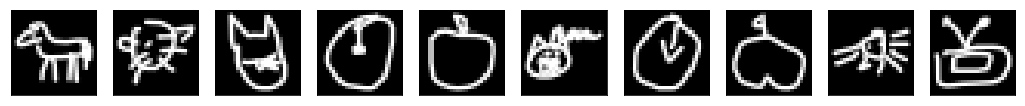

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'work/real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# 特殊领域知识

因为大家涂鸦的时候通常只会画轮廓，我们可以根据这点将source data做点边缘侦测处理，让source data更像target data一点。

## Canny 边缘检测
算法这边不赘述，只教大家怎么用。若有兴趣欢迎参考wiki或[这里](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19)。

cv2.Canny使用非常方便，只需要两个参数: low_threshold, high_threshold。

```cv2.Canny(image, low_threshold, high_threshold)```

简单来说就是当边缘值超过high_threshold，我们就确定它是edge。如果只有超过low_threshold，那就先判断一下再决定是不是edge。

以下我们直接拿源数据做做看。

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


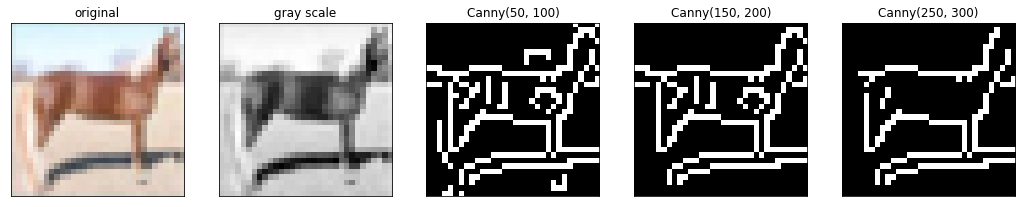

In [ ]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'work/real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')

# 数据处理

在这里我故意将数据做成可以使用paddle.io.datasets的形式，所以只要使用该函式便可以做出一个datasets。

transform的部分请参考以下注解。

In [ ]:
import cv2
import numpy as np
import paddle

import paddle.optimizer as optim
from paddle.io import DataLoader
from paddle.vision.datasets import DatasetFolder
from paddle.nn import Sequential, Conv2D, BatchNorm1D, BatchNorm2D, ReLU, MaxPool2D, Linear
from paddle.vision.transforms import Compose, Grayscale, Transpose, RandomHorizontalFlip, RandomRotation, Resize, ToTensor

In [ ]:
class Canny(paddle.vision.transforms.transforms.BaseTransform):
    def __init__(self, low, high, keys=None):
        super(Canny, self).__init__(keys)
        self.low = low
        self.high = high

    def _apply_image(self, img):
        Canny = lambda img: cv2.Canny(np.array(img), self.low, self.high)
        return Canny(img)

In [ ]:
source_transform = Compose([
    RandomHorizontalFlip(),
    RandomRotation(15),
    Grayscale(),
    Canny(low=170, high=300),
    # Transpose(),
    ToTensor()
    ])
target_transform = Compose([
    Grayscale(),
    Resize((32, 32)),
    RandomHorizontalFlip(),
    RandomRotation(15, fill=(0,)),
    ToTensor()
    ])

source_dataset = DatasetFolder('work/real_or_drawing/train_data', transform=source_transform)
target_dataset = DatasetFolder('work/real_or_drawing/test_data', transform=target_transform)

source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# 模型

特征提取器: 典型的VGG-like叠法。

标签预测 / 领域分类: MLP到尾。

相信作业写到这边大家对以下的层都很熟悉，因此不再赘述。

In [ ]:
class FeatureExtractor(paddle.nn.Layer):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = Sequential(
            Conv2D(1, 64, 3, 1, 1),
            BatchNorm2D(64),
            ReLU(),
            MaxPool2D(2),

            Conv2D(64, 128, 3, 1, 1),
            BatchNorm2D(128),
            ReLU(),
            MaxPool2D(2),

            Conv2D(128, 256, 3, 1, 1),
            BatchNorm2D(256),
            ReLU(),
            MaxPool2D(2),

            Conv2D(256, 256, 3, 1, 1),
            BatchNorm2D(256),
            ReLU(),
            MaxPool2D(2),

            Conv2D(256, 512, 3, 1, 1),
            BatchNorm2D(512),
            ReLU(),
            MaxPool2D(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(paddle.nn.Layer):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = Sequential(
            Linear(512, 512),
            ReLU(),

            Linear(512, 512),
            ReLU(),

            Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(paddle.nn.Layer):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = Sequential(
            Linear(512, 512),
            BatchNorm1D(512),
            ReLU(),

            Linear(512, 512),
            BatchNorm1D(512),
            ReLU(),

            Linear(512, 512),
            BatchNorm1D(512),
            ReLU(),

            Linear(512, 512),
            BatchNorm1D(512),
            ReLU(),

            Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# 预处理

这里我们选用Adam来当优化器。

In [ ]:
feature_extractor = FeatureExtractor()
label_predictor = LabelPredictor()
domain_classifier = DomainClassifier()

class_criterion = paddle.nn.loss.CrossEntropyLoss()
domain_criterion = paddle.nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(parameters=feature_extractor.parameters())
optimizer_C = optim.Adam(parameters=label_predictor.parameters())
optimizer_D = optim.Adam(parameters=domain_classifier.parameters())

# 开始训练

## 如何实作DaNN?

理论上，在原始论文中是加上梯度反转层，并将特征提取器 / 标签预测器 / 领域分类器 一起进行训练，但其实我们也可以交换的训练领域分类器 & 特征提取器(就像在训练对抗生成网络的生成器 & 辨别器一样)，这也是可行的。

在code实现中，我们采取后者的方式，毕竟大家上个作业就是GAN，应该会比较熟悉:)。

## 小提醒
* 原文中的lambda(控制域名对抗性损失的系数)是有适应性的版本，如果有兴趣可以参考[原文](https://arxiv.org/pdf/1505.07818.pdf)。以下为了方便固定设置0.1。
* 因为我们完全没有目标的标签，所以结果如何，只好去kaggle看看啰:)?

In [ ]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: 调控adversarial的loss系数。
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    # total_hit: 计算目前对了几笔 total_num: 目前经过了几笔
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        # source_data = source_data.cuda()
        # source_label = source_label.cuda()
        # target_data = target_data.cuda()
        
        # 我们把source data和target data混在一起，否则batch_norm可能会算错 (两边的data的mean/var不太一样)
        mixed_data = paddle.concat([source_data, target_data], axis=0)
        domain_label = paddle.zeros([source_data.shape[0] + target_data.shape[0], 1])
        # 设定source data的label为1
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : 训练Domain Classifier
        feature = feature_extractor(mixed_data)
        # 因为我们在Step 1不需要训练Feature Extractor，所以把feature detach避免loss backprop上去。
        domain_logits = domain_classifier(feature.detach())
        # print('domain_logits.shape:', domain_logits.shape, 'domain_label.shape:', domain_label.shape)
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.numpy()[0]
        # print('loss:', loss)
        loss.backward()
        optimizer_D.step()

        # Step 2 : 训练Feature Extractor和Domain Classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss为原本的class CE - lamb * domain BCE，相减的原因同GAN中的Discriminator中的G loss。
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.numpy()[0]
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.clear_grad()
        optimizer_F.clear_grad()
        optimizer_C.clear_grad()
        # print('class_logits.shape:', class_logits.shape, 'source_label.shape:', source_label.shape)
        # print('class_logits[0]:', class_logits[0], 'source_label[0]:', source_label[0])
        total_hit += np.sum((paddle.argmax(class_logits, axis=1) == source_label).numpy())
        total_num += source_data.shape[0]
        print(i, end='\r')

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

# 训练200 epochs
for epoch in range(200):
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=0.1)

    paddle.save(feature_extractor.state_dict(), f'extractor_model.pdparams')
    paddle.save(label_predictor.state_dict(), f'predictor_model.pdparams')

    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:637: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


8
epoch   0: train D loss: 0.2486, train F loss: 2.0155, acc 0.2744
epoch   1: train D loss: 0.5980, train F loss: 1.5812, acc 0.4206
epoch   2: train D loss: 0.4825, train F loss: 1.4725, acc 0.4686
epoch   3: train D loss: 0.5002, train F loss: 1.3849, acc 0.4962
epoch   4: train D loss: 0.5209, train F loss: 1.3099, acc 0.5218
epoch   5: train D loss: 0.5455, train F loss: 1.2892, acc 0.5250
epoch   6: train D loss: 0.5452, train F loss: 1.2329, acc 0.5598
epoch   7: train D loss: 0.5228, train F loss: 1.1991, acc 0.5624
epoch   8: train D loss: 0.5520, train F loss: 1.1609, acc 0.5766
epoch   9: train D loss: 0.5303, train F loss: 1.1286, acc 0.5898
epoch  10: train D loss: 0.5484, train F loss: 1.1247, acc 0.5904
epoch  11: train D loss: 0.5465, train F loss: 1.1060, acc 0.5942
epoch  12: train D loss: 0.5174, train F loss: 1.0516, acc 0.6154
epoch  13: train D loss: 0.5401, train F loss: 1.0447, acc 0.6216
epoch  14: train D loss: 0.5224, train F loss: 1.0034, acc 0.6364
epoch  1

# 推断

就跟前几次作业一样。这里我使用pandas来生产csv。

此外，200 epochs的准确度可能会不太稳定，可以多丢几次或训练久一点。

In [ ]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, (test_data, _) in enumerate(test_dataloader):
    test_data = test_data

    class_logits = label_predictor(feature_extractor(test_data))

    x = paddle.argmax(class_logits, axis=1).detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('work/DaNN_submission.csv',index=False)